## Optimizing eRHIC cooler parameters 

This notebook is intended to develop the tools necessary to optimize a cooling configuration. It's also meant to be a generic testbed for developing future Sirepo features. 

Start by checking out and compiling JSPEC:

    git clone https://github.com/radiasoft/electroncooling.git
    cd electroncooling
    mkdir build
    cd build
    cmake ..
    make -j5
    cp $HOME/jupyter/StaffScratch/sjcrs/eRHIC.tfs .

This `.tfs` file was produced by madx from the eRHIC lattice supplied by Boaz. Once you have compiled JSPEC in your local directory, set the path to your local installation's 'build' path in `buildpath`

Also, if you have access to a RSMPI node, set `RSMPI=True` here

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import optimize

buildpath = "/home/vagrant/jupyter/github/electroncooling/build/"
RSMPI=False

#### Pass the parameters of the proposed eRHIC system to JSPEC:

We create an object with the proposed eRHIC values stored, so we can simply and easily modify one of them & re-run JSPEC. We then define a function that takes this object as an argument, writes the input file, and runs the job (either locally or submitted to the RSMPI cluster). 

Open the first collapsed cell below to see all of the parameters and their default values.

The second collapsed sell sets the default parameters for the 41 GeV beam concept.

The third collapsed cell contains the function `Update_eRHIC_Config(obj,rsmpi=False)` that parses this class into an input file and runs the JSPEC executable. If you have access to a RSMPI node, pass `rsmpi=True` and you will experience a ~4x speedup

In [2]:
class JSPEC_config:
    def __init__(self):
        self.dynamic          = True #Follow through many turns or just calculate instantaneous rates?
        self.suffix           = "dump"
        #Ion section
        self.ion_mass         = 938.272 #in MeV
        self.ke               = 2.5e4   # 25 GeV in MeV
        self.charge_number    = 1
        self.norm_emit_x      = 2.5e-06 #microns
        self.norm_emit_y      = 2.5e-06 #microns
        self.p_spread         = 0.001
        self.particle_number  = 1.34e12
        self.rms_bunch_length = 0.7
        #IBS Section
        self.lattice          = "eRHIC.tfs"
        self.nu               = 100
        self.nv               = 100
        self.log_c            = 20.6  #Total guess
        self.coupling         = 0.0
        #Cooler Section
        self.length           = 130.0 # in meters
        self.section_number   = 1
        self.bfield           = 1.0   # in Tesla
        self.bet_x            = 10.0  #Placeholder values, take value from lattice ?
        self.bet_y            = 10.0  # ^
        self.disp_x           = 0.0   # ^
        self.disp_y           = 0.0   # ^
        self.alpha_x          = 0.0   # ^
        self.alpha_y          = 0.0   # ^
        self.disp_dx          = 0.0   # ^
        self.disp_dy          = 0.0   # ^
        # e beam section
        self.temp_tr          = 0.01  #in eV
        self.temp_l           = 0.01  #in eV        
        self.shape            = "bunched_gaussian"
        self.radius           = 0.009  # in meters, only for DC_UNIFORM or BUNCHED_UNIFORM e beams
        self.current          = 4.0    # electron current in Amperes, only for DC_UNIFORM or BUNCHED_UNIFORM 
        self.sigma_x          = 3e-5  #Just a guess (in meters)
        self.sigma_y          = 3e-5  #^
        self.sigma_z          = 0.05  #^ in meters. Used for "bunched gaussian"
        self.ebeam_length     = 0.05   # in meters. Only used for "bunched_uniform"
        self.e_number         = 1.5605e10
        self.ion_sample       = "MONTE_CARLO" #How the ion bunch is sampled, MONTE_CARLO or SINGLE_PARTICLE
        self.sample_number    = 500000 #(Monte Carlo): Total number of ions sampled (Single Particle): Ions sampled in each dimension
        self.force_formula    = "parkhomchuk"  #Could be DERBENEVSKRINSKY, MESHKOV, UNMAGNETIZED or BUDKER for unmagnetized 
        self.ibs              = "on"
        self.ecool            = "on"
        self.time             = 2000.0
        self.step_number      = 100 #so, 2000/100 = 20s samplings by default for dynamic simulation
        self.model            = "RMS" #or "RMS"
        self.ref_bet_x        = 10.0
        self.ref_bet_y        = 10.0
        self.ref_alf_x        = 0.0
        self.ref_alf_y        = 0.0
        self.ref_disp_x       = 0.0
        self.ref_disp_y       = 0.0
        self.ref_disp_dx      = 0.0
        self.ref_disp_dy      = 0.0
        self.print            = False

In [3]:
class JSPEC_41_config:
    def __init__(self):
        self.dynamic          = True #Follow through many turns or just calculate instantaneous rates?
        self.suffix           = "dump"
        #Ion section
        self.ion_mass         = 938.272 #in MeV
        self.ke               = 4.1e4   # 25 GeV in MeV
        self.charge_number    = 1
        self.norm_emit_x      = 2.5e-06 #microns
        self.norm_emit_y      = 0.4e-06 #microns
        self.p_spread         = 0.001
        self.particle_number  = 1.34e12
        self.rms_bunch_length = 0.07
        #IBS Section
        self.lattice          = "eRHIC.tfs"
        self.nu               = 100
        self.nv               = 100
        self.log_c            = 20.6  #Total guess
        self.coupling         = 0.0
        #Cooler Section
        self.length           = 130.0 # in meters
        self.section_number   = 1
        self.bfield           = 1.0   # in Tesla
        self.bet_x            = 10.0  #Placeholder values, take value from lattice ?
        self.bet_y            = 10.0  # ^
        self.disp_x           = 0.0   # ^
        self.disp_y           = 0.0   # ^
        self.alpha_x          = 0.0   # ^
        self.alpha_y          = 0.0   # ^
        self.disp_dx          = 0.0   # ^
        self.disp_dy          = 0.0   # ^
        # e beam section
        self.temp_tr          = 0.01  #in eV
        self.temp_l           = 0.01  #in eV        
        self.shape            = "bunched_gaussian"
        self.radius           = 0.009  # in meters, only for DC_UNIFORM or BUNCHED_UNIFORM e beams
        self.current          = 4.0    # electron current in Amperes, only for DC_UNIFORM or BUNCHED_UNIFORM 
        self.sigma_x          = 3e-5  #Just a guess (in meters)
        self.sigma_y          = 3e-5  #^
        self.sigma_z          = 0.03  #^ in meters. Used for "bunched gaussian"
        self.ebeam_length     = 0.05   # in meters. Only used for "bunched_uniform"
        self.e_number         = 1.5605e10
        self.ion_sample       = "MONTE_CARLO" #How the ion bunch is sampled, MONTE_CARLO or SINGLE_PARTICLE
        self.sample_number    = 500000 #(Monte Carlo): Total number of ions sampled (Single Particle): Ions sampled in each dimension
        self.force_formula    = "parkhomchuk"  #Could be DERBENEVSKRINSKY, MESHKOV
        self.ibs              = "on"
        self.ecool            = "on"
        self.time             = 2000.0
        self.step_number      = 100 #so, 2000/100 = 20s samplings by default for dynamic simulation
        self.model            = "RMS" #or "RMS"
        self.ref_bet_x        = 10.0
        self.ref_bet_y        = 10.0
        self.ref_alf_x        = 0.0
        self.ref_alf_y        = 0.0
        self.ref_disp_x       = 0.0
        self.ref_disp_y       = 0.0
        self.ref_disp_dx      = 0.0
        self.ref_disp_dy      = 0.0
        self.print            = False

In [3]:
def Update_eRHIC_Config(obj,rsmpi=False):
    
    os.chdir(buildpath)
    
    #One quick sanity check
    if (obj.sample_number > 1001) and (obj.ion_sample is "SINGLE_PARTICLE"):
        print("This choice of parameters could swamp the memory. Sure you want " + str(obj.sample_number) + "^3 samples?")
    
    file1 = open("jspec_"+obj.suffix+".in","w")#write mode     
    file1.write("\n")
    file1.write("section_scratch\n")
    file1.write("        ion_mass = "+str(obj.ion_mass)+"\n")
    file1.write("        ion_ke = "+str(obj.ke)+"\n")
    file1.write("        ion_gamma = 1 + ion_ke/ion_mass\n")
    file1.write("section_ion\n")
    file1.write("        charge_number = "+str(obj.charge_number)+"\n")
    file1.write("        mass = ion_mass\n")
    file1.write("        kinetic_energy = ion_ke\n")
    file1.write("        norm_emit_x = "+str(obj.norm_emit_x)+"\n")
    file1.write("        norm_emit_y = "+str(obj.norm_emit_y)+"\n")
    file1.write("        momentum_spread = "+str(obj.p_spread)+"\n")
    file1.write("        particle_number = "+str(obj.particle_number)+"\n")
    file1.write("        rms_bunch_length = "+str(obj.rms_bunch_length)+"\n")
    file1.write("section_ring\n")
    file1.write("        lattice = "+obj.lattice+"\n")
    file1.write("section_ibs\n")
    file1.write("        nu = "+str(obj.nu)+"\n")
    file1.write("        nv = "+str(obj.nv)+"\n")
    file1.write("        log_c = "+str(obj.log_c)+"\n")
    file1.write("        coupling = "+str(obj.coupling)+"\n")
    file1.write("section_cooler\n")
    file1.write("        length = "+str(obj.length)+"\n")
    file1.write("        section_number = "+str(obj.section_number)+"\n")
    file1.write("        magnetic_field = "+str(obj.bfield)+"\n")
    file1.write("        bet_x = "+str(obj.bet_x)+"\n")
    file1.write("        bet_y = "+str(obj.bet_y)+"\n")
    file1.write("        disp_x = "+str(obj.disp_x)+"\n")
    file1.write("        disp_y = "+str(obj.disp_y)+"\n")
    file1.write("        alpha_x = "+str(obj.alpha_x)+"\n")
    file1.write("        alpha_y = "+str(obj.alpha_y)+"\n")
    file1.write("        disp_dx = "+str(obj.disp_dx)+"\n")
    file1.write("        disp_dy = "+str(obj.disp_dy)+"\n")
    file1.write("section_e_beam\n")
    file1.write("        gamma = ion_gamma\n")
    file1.write("        tmp_tr = "+str(obj.temp_tr)+"\n")
    file1.write("        tmp_l = "+str(obj.temp_l)+"\n")
    file1.write("        shape = "+obj.shape+"\n")
    file1.write("        radius = "+str(obj.radius)+"\n")
    file1.write("        current = "+str(obj.current)+"\n")
    file1.write("        sigma_x = "+str(obj.sigma_x)+"\n")
    file1.write("        sigma_y = "+str(obj.sigma_y)+"\n")
    file1.write("        sigma_z = "+str(obj.sigma_z)+"\n")
    file1.write("        length = "+str(obj.ebeam_length)+"\n")
    file1.write("        e_number = "+str(obj.e_number)+"\n")
    file1.write("section_ecool\n")
    file1.write("        sample_number = "+str(obj.sample_number)+"\n")
    file1.write("        ion_sample = "+obj.ion_sample+"\n")
    file1.write("        force_formula = "+obj.force_formula+"\n")
    file1.write("section_run\n")
    file1.write("        create_ion_beam\n")
    file1.write("        create_ring\n")
    file1.write("        create_e_beam\n")
    file1.write("        create_cooler\n")
    file1.write("section_simulation\n")
    file1.write("        ibs = "+obj.ibs+"\n")
    file1.write("        e_cool = "+obj.ecool+"\n")
    file1.write("        time = "+str(obj.time)+"\n")
    file1.write("        step_number = "+str(obj.step_number)+"\n")
    file1.write("        output_file = JSPEC"+obj.suffix+".SDDS\n")
    file1.write("        model = "+obj.model+"\n")
    file1.write("        ref_bet_x = "+str(obj.ref_bet_x)+"\n")
    file1.write("        ref_bet_y = "+str(obj.ref_bet_y)+"\n")
    file1.write("        ref_alf_x = "+str(obj.ref_alf_x)+"\n")
    file1.write("        ref_alf_y = "+str(obj.ref_alf_y)+"\n")
    file1.write("        ref_disp_x = "+str(obj.ref_disp_x)+"\n")
    file1.write("        ref_disp_y = "+str(obj.ref_disp_y)+"\n")
    file1.write("        ref_disp_dx = "+str(obj.ref_disp_dx)+"\n")
    file1.write("        ref_disp_dy = "+str(obj.ref_disp_dx)+"\n")
    file1.write("section_run\n")
    if obj.dynamic is True:
        file1.write("        run_simulation\n")
    else:
        file1.write("        calculate_ecool\n")
        file1.write("        calculate_ibs\n")
        file1.write("        total_expansion_rate\n")

    file1.close()
    
    os.chdir(buildpath)
    
    #With this option, the beam is sampled over the course of multiple turns
    if obj.dynamic is True:
        if rsmpi:
            os.system('rsmpi -n 1 ./jspec jspec_'+obj.suffix+'.in' )
        else:
            os.system('./jspec jspec_'+obj.suffix+'.in')
            
        return #Parsing output happens elsewhere for a dynamic run
    
    else:
        #Run and create a file with the instantaneous rates
        if rsmpi:
            os.system('rsmpi -n 1 ./jspec jspec_'+obj.suffix+'.in > instantaneous_rates.txt' )
        else:
            os.system('./jspec jspec_'+obj.suffix+'.in > instantaneous_rates.txt')
            
        #Parse that file and return the values
        rate_file = open(r"instantaneous_rates.txt","r")
        #Skip the first 4 lines
        [rate_file.readline() for i in range(4)]
        e_rate = rate_file.readline()
        ibs_rate = rate_file.readline()
        total_rate = rate_file.readline()
        rate_file.close()
        
        if obj.print:
            print(e_rate)
            print(ibs_rate)
            print(total_rate)
        
        def parse(rate):
            parse = (rate.split(":")[1].rstrip()).split("  ")
            parse = [float(i) for i in parse]
            return parse
        
        #The 3 parameters are horizontal, vertical, longitudinal
        return parse(e_rate), parse(ibs_rate), parse(total_rate)

### Visualization Demo

Here we define a function to make a grid of plots of output parameters. We can use this function to overlay the output from one or more sets of configuration parameters. 

This is useful for making comparisons that are not yet possible in Sirepo. 

In [24]:
def DisplayTrial(sdds_file,label=None):
    names=["t","emit_x","emit_y","dp/p","sigma_s",
           "rx","ry","rs","rx_ibs","ry_ibs","rs_ibs","rx_ecool","ry_ecool","rs_ecool",
          "rf_voltage","luminosity"]
    df = pd.read_csv(sdds_file,skiprows=21,
                     index_col=False,delim_whitespace=True,
                     names=names)
    df = df.sort_values(by='t',ascending=True)
    #Convert to microns from meters
    df["emit_x"] = df["emit_x"]*1e6
    df["emit_y"] = df["emit_y"]*1e6

   
    plt.subplot(4,3,1)
    plt.plot(df["t"],df["emit_x"],label=label)
    plt.xlabel("time")
    plt.ylabel(r"emit $x$")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(r"Ion $x$ Emittance")

    plt.subplot(4,3,2)
    plt.plot(df["t"],df["emit_y"])
    plt.xlabel("time")
    plt.ylabel(r"emit $y$")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(r"Ion $y$ Emittance")
    
    plt.subplot(4,3,3)
    plt.plot(df["t"],df["sigma_s"])
    plt.xlabel("time")
    plt.ylabel("sigma $s$")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title("Ion Bunch Length")

#This plots the scatterplot of y vs length, with color coding time from blue to red
# showing a trajectory. Might not be useful, but I'm storing the code/idea here
#    plt.scatter(df["emit_y"],df["sigma_s"],c=df.index,cmap=plt.cm.coolwarm)
#    plt.xlabel(r"emit $y$")
#    plt.ylabel(r"sigma $s$")
#    plt.title("Time-dependent trajectory")
    
    plt.subplot(4,3,4)
    plt.plot(df["t"],df["rx"])
    plt.xlabel("time")
    plt.ylabel(r"$x$ cooling rate")
    plt.title(r"$x$ Cooling rate (Total)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.subplot(4,3,5)
    plt.plot(df["t"],df["rx_ecool"])
    plt.xlabel("time")
    plt.title(r"$x$ cooling rate")
    plt.title(r"$x$ Cooling rate (e-cool)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.subplot(4,3,6)
    plt.plot(df["t"],df["rx_ibs"])
    plt.xlabel("time")
    plt.ylabel(r"$x$ cooling rate")
    plt.title(r"$x$ Cooling rate(IBS)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.subplot(4,3,7)
    plt.plot(df["t"],df["ry"])
    plt.xlabel("time")
    plt.ylabel(r"$y$ rate")
    plt.title(r"$y$ Cooling rate (Total)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.subplot(4,3,8)
    plt.plot(df["t"],df["ry_ecool"])
    plt.xlabel("time")
    plt.ylabel(r"$y$ cooling rate")
    plt.title(r"$y$ Cooling rate (e-cool)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.subplot(4,3,9)
    plt.plot(df["t"],df["ry_ibs"])
    plt.xlabel("time")
    plt.ylabel(r"$y$ cooling rate")
    plt.title(r"$y$ Cooling rate(IBS)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.subplot(4,3,10)
    plt.plot(df["t"],df["rs"])
    plt.xlabel("time")
    plt.ylabel(r"$s$ cooling rate")
    plt.title(r"$s$ Cooling rate (Total)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.subplot(4,3,11)
    plt.plot(df["t"],df["rs_ecool"])
    plt.xlabel("time")
    plt.ylabel(r"$s$ cooling rate")
    plt.title(r"$s$ Cooling rate (e-cool)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.subplot(4,3,12)
    plt.plot(df["t"],df["rs_ibs"])
    plt.xlabel("time")
    plt.ylabel(r"$s$ cooling rate")
    plt.title(r"$s$ Cooling rate (IBS)")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout()
    


Finished calculating config 1



/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a pr

<Figure size 432x288 with 0 Axes>

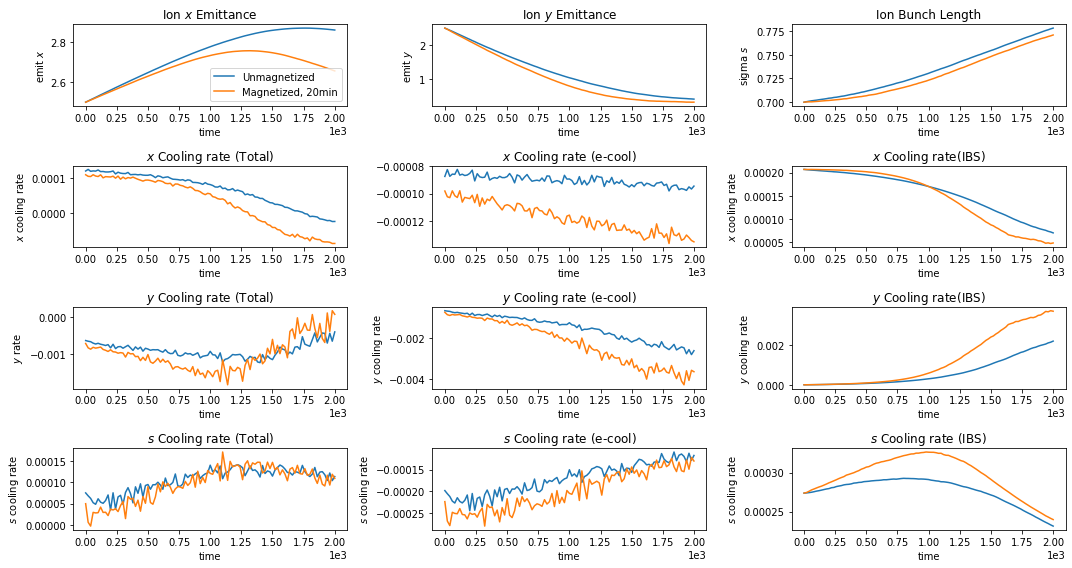

In [46]:
#Define the object with all the default values
config1 = JSPEC_config()
#Make some of our own changes
config1.suffix = "DUMP1"
config1.model = "RMS"
config1.force_formula = "BINNEY" #"UNMAGNETIZED"
config1.sample_number = 1e6
config1.bfield = 1.0
config1.sigma_x = 0.0002
config1.sigma_y = 0.0002
config1.sigma_z = 0.07
config1.bet_x = 10
config1.bet_y = 40
config1.disp_x = 0.1
config1.disp_y = 4
config1.temp_tr = 0.0001
config1.temp_long = 0.01
config1.e_number = 5e10 #up from  1.6e10 
#By default, this is using the Particle (macro-particle) model
A = Update_eRHIC_Config(config1,rsmpi=RSMPI)
print("Finished calculating config 1\n")

config3 = JSPEC_config()
config3.model  = "RMS"  # Switch from Particle model to using the beam moments
config3.sample_number = 1e6

config3.bfield = 5.06
config3.sigma_x = 0.0002
config3.sigma_y = 0.0002
config3.sigma_z = 0.07
config3.bet_x = 10
config3.bet_y = 40
config3.disp_x = 0.1
config3.disp_y = 4
config3.temp_tr = 0.0001
config3.temp_long = 0.01
config3.e_number = 5e10 #up from  1.6e10 
config3.suffix = "DUMP3"
Update_eRHIC_Config(config3,rsmpi=RSMPI)
#Pass the function output to our parser class

#Read the output files & make a standard figure
plt.clf()
plt.figure(figsize=(15,8))
cooltime1 = DisplayTrial("JSPECDUMP1.SDDS",label="Unmagnetized")
cooltime3 = DisplayTrial("JSPECDUMP3.SDDS",label="Magnetized, 20min")
#Only draw our legend once
plt.subplot(4,3,1)
plt.legend(loc='lower right')
plt.show()

### Parameter Scans

We can calculate the instantaneous cooling rate at $t=0$ by setting the member variable `dynamic=False`. This allows us to scan across a range of parameter values to see how the instantaneous cooling rate changes. Here we create a convencience class for parsing out the 9 possible rate values that one may want to plot.

In [4]:
class Rates_object:
    def __init__(self,e_rate,ibs_rate,total_rate):
        #The 3 elements of each list are are horizontal, vertical, longitudinal
        self.e_rate_h = e_rate[0]
        self.e_rate_v = e_rate[1]
        self.e_rate_l = e_rate[2]
        self.ibs_rate_h = ibs_rate[0]
        self.ibs_rate_v = ibs_rate[1]
        self.ibs_rate_l = ibs_rate[2]
        self.total_rate_h = total_rate[0]
        self.total_rate_v = total_rate[1]
        self.total_rate_l = total_rate[2]

Here's an example of calculating the rates for a single set of parameters:

In [45]:
config3 = JSPEC_config()
config3.model  = "RMS"  # Switch from Particle model to using the beam moments
config3.sample_number = 1e7
config3.dynamic = False


config3.bfield = 5.06
config3.sigma_x = 0.0002
config3.sigma_y = 0.0002
config3.sigma_z = 0.07
config3.bet_x = 10 # 16
config3.bet_y = 40 # 28
config3.disp_x = 0.1
config3.disp_y = 4.0
config3.temp_tr = 1e-4
config3.temp_long = 0.01
config3.e_number = 5e10 #up from  1.6e10 

config3.force_formula = "PARKHOMCHUK"
#config3.suffix = "DUMP3"
#Pass the function output to our parser class
RO = Rates_object(*Update_eRHIC_Config(config3,rsmpi=RSMPI))
    
print(str((-1/(RO.total_rate_v))/60.)[:6]+" minute total vertical cool time")
print(RO.e_rate_h,RO.e_rate_v,RO.e_rate_l)
print(RO.ibs_rate_h,RO.ibs_rate_v,RO.ibs_rate_l)
print(RO.total_rate_h,RO.total_rate_v,RO.total_rate_l)

20.586 minute total vertical cool time
-0.0001013 -0.0008185 -0.000262
0.0002067 8.86e-06 0.0002736
0.0001053 -0.0008096 1.159e-05


0.1
47.947 minute total vertical cool time
0.6210526315789474
41.081 minute total vertical cool time
1.142105263157895
32.808 minute total vertical cool time
1.6631578947368424
27.520 minute total vertical cool time
2.18421052631579
24.560 minute total vertical cool time
2.7052631578947373
23.112 minute total vertical cool time
3.2263157894736847
22.037 minute total vertical cool time
3.747368421052632
21.639 minute total vertical cool time
4.268421052631579
21.524 minute total vertical cool time
4.7894736842105265
21.285 minute total vertical cool time
5.310526315789474
21.583 minute total vertical cool time
5.831578947368421
22.060 minute total vertical cool time
6.352631578947369
22.308 minute total vertical cool time
6.873684210526316
22.753 minute total vertical cool time
7.394736842105264
22.815 minute total vertical cool time
7.915789473684211
23.352 minute total vertical cool time
8.436842105263159
24.524 minute total vertical cool time
8.957894736842105
24.377 minute total ver

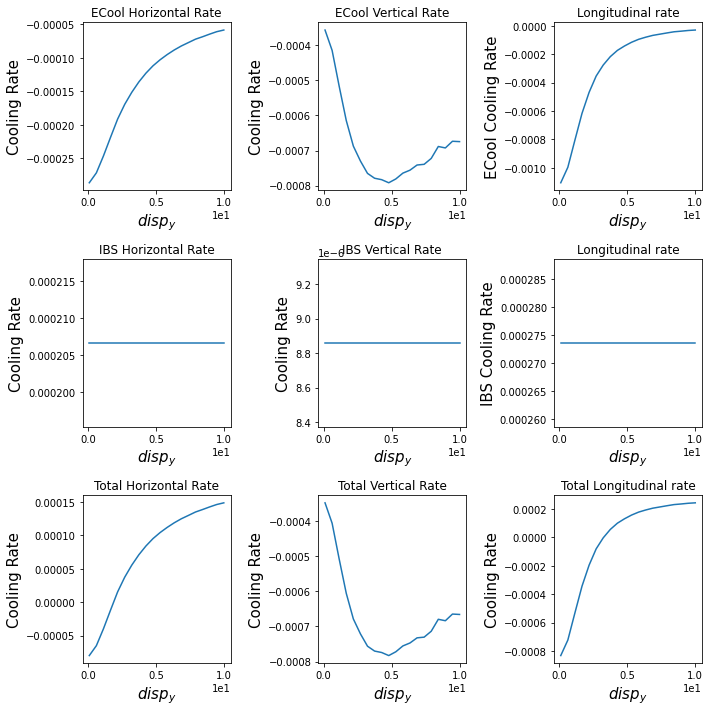

In [43]:
plt.figure(figsize=(10,10))

#Running notes : cooling proportional to bet_x (beta = 50 gives good cooling rates)
# ~linear in e_number
# ~linear in cooler length
# ebeam sigma_x and sigma_y want to be small (1e-5 or so)

yval1 = []
yval2 = []
yval3 = []
yval4 = []
yval5 = []
yval6 = []
yval7 = []
yval8 = []
yval9 = []
    
#The x-value will scan across different normalized ion emittances in the x direction
xrange = np.linspace(0.1,10,20)
for i in xrange:
    print(i)
    #Define the object with all the default values
    config1 = JSPEC_config()
    #Make some of our own changes
    config1.sigma_y = 3e-5
    config1.sigma_z  = 0.2 
    config1.model = "RMS"
    config1.ibs   = "on"
    config1.sample_number = 1e8
    config1.rms_bunch_length = i 
    config1.dynamic = False
       
    config3 = JSPEC_config()
    config3.dynamic = False
    config3.sample_number = 1e8        
    config3.bfield = 5.06
    config3.sigma_x = 0.0002
    config3.sigma_y = 0.0002
    config3.sigma_z = 0.07
    config3.bet_x = 16
    config3.bet_y = 28
    config3.disp_x = 0.3
    config3.disp_y = i
    config3.temp_tr = 0.0001
    config3.temp_long = 0.01
    config3.e_number = 5e10 #up from  1.6e10       
        
    #Pass the function output to our parser class
    RO = Rates_object(*Update_eRHIC_Config(config3,rsmpi=RSMPI))
   
    print(str((-1/(RO.total_rate_v))/60.)[:6]+" minute total vertical cool time")
    
    yval1.append(RO.e_rate_h)
    yval2.append(RO.e_rate_v)
    yval3.append(RO.e_rate_l)
    yval4.append(RO.ibs_rate_h)
    yval5.append(RO.ibs_rate_v)
    yval6.append(RO.ibs_rate_l)
    yval7.append(RO.total_rate_h)
    yval8.append(RO.total_rate_v)
    yval9.append(RO.total_rate_l)
        
    xlabel = r"$disp_y$"
    
plt.subplot(3,3,1)  
plt.plot(xrange,yval1)#,label=str(temp_tr) + "eV")
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.title("ECool Horizontal Rate")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,2)
plt.plot(xrange,yval2)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.title("ECool Vertical Rate")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,3)
plt.plot(xrange,yval3)
plt.title("Longitudinal rate")
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("ECool Cooling Rate",fontsize=15)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,4)    
plt.plot(xrange,yval4)#,label=str(temp_tr) + "eV")
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.title("IBS Horizontal Rate")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,5)
plt.plot(xrange,yval5)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.title("IBS Vertical Rate")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,6)
plt.plot(xrange,yval6)
plt.title("Longitudinal rate")
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("IBS Cooling Rate",fontsize=15)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,7)    
plt.plot(xrange,yval7)#,label=str(temp_tr) + "eV")
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.title("Total Horizontal Rate")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,8)
plt.plot(xrange,yval8)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.title("Total Vertical Rate")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(3,3,9)
plt.plot(xrange,yval9)
plt.title("Total Longitudinal rate")
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("Cooling Rate",fontsize=15)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
plt.tight_layout()
#plt.subplot(3,3,1)
#plt.legend(loc='lower right')
plt.show()


In [10]:
#Uncomment these lines below to test with the Sirepo default "booster" config
# (and also change the arguments in DisplayTrial below to match)
#config3 = BOOSTER_config()
#config3.bfield = 0.039
#config3.suffix = "DUMP3"
#Update_eRHIC_Config(config3)

#config4 = BOOSTER_config()
#config4.bfield = 0.05
#config4.suffix = "DUMP4"
#Update_eRHIC_Config(config4)

#Read the output files & make a standard figure
#plt.clf()
#plt.figure(figsize=(15,8))
#cooltime1 = DisplayTrial("JSPECDUMP3.SDDS",label="B = 0.039 T")
#cooltime2 = DisplayTrial("JSPECDUMP4.SDDS",label="B = 0.05 T")
#plt.subplot(4,3,1)
#plt.legend(loc='lower right')
#plt.show()

### Nonlinear optimization (Not Tested)

Here we could let Scipy figure out the combination of parameters that yields a 20 minute cooling time. This interface is very slow, compared to the compiled C++ optimizer in a branch in electroncooling in Github.

In [ ]:
#For the moment, the parameters you can optimize are hard-coded in the 
# defintion of CalculateRate 
def CalculateRateMultiD(*args):
    
    #Submit this iteration as a job & produce an output file
    config = JSPEC_config()

    #Here we hide the scale and bounds of each variable
    # from the optimizer. That way the variables that the
    # optimizer sees are all scaled from 0 to 1
    config.bfield = (0.001 + args[0][0]*10.0) 
    config.sigma_x = (1e-4 + args[0][1]*5e-4)
    config.sigma_y = (1e-4 + args[0][2]*5e-4)
    config.sigma_z = (0.05 + args[0][3]*0.45)
    config.bet_x   = args[0][4]*50.0
    config.bet_y   = args[0][5]*50.0
    config.disp_x  = args[0][6]*0.5
    config.disp_y  = args[0][7]*0.5
    config.e_number = (0.5 + args[0][8]*2.5) * 1e10
    
    config.sample_number = 5e7
    config.model = "RMS" #Using moments smooths the space
    config.suffix = "_MIN" #Define the filename for checking the output
    
    config.dynamic = False
    
    #Pass the function output to our parser class
    RO = Rates_object(*Update_eRHIC_Config(config,rsmpi=RSMPI)) 
 
    
    cooltime = (1.0 / RO.total_rate_v)/60.
    
    #Keep an eye on the parameter search progress/attempts
    print(RO.total_rate_v)
    print(args, cooltime)
 
    return abs(cooltime)

#Key to these arguments: [bfield,sigma_x,sigma_y,sigma_z]
#The lower bounds for each argument
lb3d = (0., #bfield
        0.,  #sigma_x
        0.,  #sigma_y
        0.,  #sigma_z
        0.,   #bet_x
        0.,   #bet_y
        0.,   #disp_x
        0.,   #disp_y
        0.)   #e-number / 1e10
       
ub3d = (1.0, #bfield
        1.0,  #sigma_x
        1.0,  #sigma_y
        1.0,  #sigma_z
        1.0,   #bet_x
        1.0,   #bet_y
        1.0,   #disp_x
        1.0,   #disp_y
        1.0)   #e-number / 1e10

#This bounds object is passed to the modern optimize.minimize function
# which seems to be newer than the scipy version on radiasoft.jupyter
#bounds = optimize.Bounds(lb2d,ub2d)

bounds = [a for a in zip(lb3d,ub3d)]

#guess = np.array([1.5,   #bfield
#                  2e-4,  #sigma_x
#                  2e-4,  #sigma_y
#                  0.1,   #sigma_z
#                  10.,   #bet_x
#                  10.,   #bet_y
#                  0.2,   #disp_x
#                  0.2,   #disp_y
#                  1.5])  #e-number / 1e10
 
guess = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
    
min = optimize.fmin_tnc(CalculateRateMultiD,guess,bounds=bounds,approx_grad=True,disp=5)
    
#min = optimize.minimize(CalculateRateMultiD,guess,method='Nelder-Mead',bounds=bounds)    


print(min) #Array of [solution, #iterations,return code (see link above)]

#### Make a 2d surface

This takes a while, but it will draw a cooling time surface, a grid search of 2 parameters (in this case, the electron beam transverse RMS dimensions)

In [ ]:
def CalculateRate2d(*args):
    
    #Submit this iteration as a job & produce an output file
    config = JSPEC_config()

    config.sigma_x = args[0][0]
    config.sigma_y = args[0][1]
    config.sample_number = 5e7
    #config.ion_sample = "SINGLE_PARTICLE"
    #config.sample_number = 250
    config.model = "RMS" #Using moments smooths the space
    config.suffix = "_MIN" #Define the filename for checking the output
    config.ibs = "on"
    config.dynamic = False
    
    #Pass the function output to our parser class
    RO = Rates_object(*Update_eRHIC_Config(config,rsmpi=RSMPI)) 
 
    try:
        cooltime_h = (1.0 / RO.e_rate_h)/60.
    except:
        cooltime_h = 0.0
    try:
        cooltime_v = (1.0 / RO.e_rate_v)/60.
    except:
        cooltime_v = 0.0
    try:
        cooltime_l = (1.0 / RO.e_rate_l)/60.
    except:
        cooltime_l = 0.0

    print(RO.e_rate_h,RO.e_rate_v,RO.e_rate_l)
    
 
    return cooltime_v#,cooltime_h,cooltime_l



#Key to these arguments: [sigma_x,sigma_y]
lb2d = (1e-4,1e-4) #The lower bounds for each argument
ub2d = (1e-3,1e-3)       #The upper bounds for each argument


#This bounds object is passed to the modern optimize.minimize function
# which seems to be newer than the scipy version on radiasoft.jupyter
#bounds = optimize.Bounds(lb2d,ub2d)

bounds = [a for a in zip(lb2d,ub2d)]

guess = np.array([3e-4,3e-4])

min = optimize.minimize(CalculateRate2d,guess,method='Nelder-Mead',bounds=bounds)    
print(min) #Array of [solution, #iterations,return code (see link above)]


a_bounds = np.linspace(lb2d[0],ub2d[0],10)
b_bounds = np.linspace(lb2d[1],ub2d[1],10)

surf_h = np.zeros(shape=(len(a_bounds),len(b_bounds)))
surf_v = np.zeros(shape=(len(a_bounds),len(b_bounds)))
surf_l = np.zeros(shape=(len(a_bounds),len(b_bounds)))

for i,ii in enumerate(a_bounds):
    for j,jj in enumerate(b_bounds):

        print(i,j)
        c_v, c_h, c_l = CalculateRate2d(ii,jj)
        surf_h[i,j] = c_h
        surf_v[i,j] = c_v
        surf_l[i,j] = c_l
        

plt.imshow(surf_v.T,origin='lower',extent=[lb2d[0],ub2d[0],lb2d[1],ub2d[1]],aspect='auto')
plt.xlabel(r"$\sigma_{x}$ [m]")
plt.ylabel(r"$\sigma_{y}$ [m]")
plt.title("Vertical e cooling time")
plt.colorbar()
plt.show()

plt.imshow(surf_h.T,origin='lower',extent=[lb2d[0],ub2d[0],lb2d[1],ub2d[1]],aspect='auto')
plt.xlabel(r"$\sigma_{x}$ [m]")
plt.ylabel(r"$\sigma_{y}$ [m]")
plt.title("Horizontal e cooling time")
plt.colorbar()
plt.show()

plt.imshow(surf_l.T,origin='lower',extent=[lb2d[0],ub2d[0],lb2d[1],ub2d[1]],aspect='auto')
plt.xlabel(r"$\sigma_{x}$ [m]")
plt.ylabel(r"$\sigma_{y}$ [m]")
plt.title("Longitudinal e cooling time")
plt.colorbar()
plt.show()


# Pick a method that allows you to specify bounds
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_tnc.html
#minimum = optimize.fmin_tnc(CalculateRate2d, 
#minimum = optimize.fmin_slsqp(CalculateRate2d,
#                            guess, #Best guess starting point
#                            approx_grad=True, #Since we haven't defined a jacobian, only for fmin_tnc
#                            bounds=bounds,
#                            disp=5) #lots of text output
 
